<a href="https://colab.research.google.com/github/maheshyadav007/research/blob/main/NPK_NPV_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import torch.nn.functional as F


In [2]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


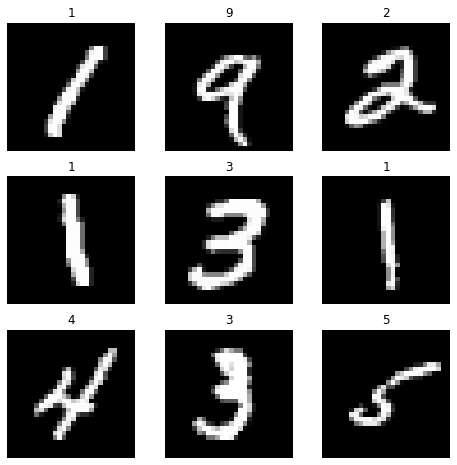

In [3]:
labels_map = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
counter = 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[counter]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
    counter += 1
plt.show()


In [4]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    correct = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        #print(X.shape,y.shape)
        # Compute prediction error
        pred, _ = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch%100 == 0:
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} Batch:{batch} [{current:>5d}/{size:>5d}]")

In [5]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred,_ = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [6]:
def get_activation_output(dataloader, model):
    gate = []
    count = 0
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            _,gate  = model(X)
            
            '''
            if count >= 1:
              gate = np.vstack((gate,g))
              
            else:
              gate = np.reshape(g, shape= (1,5))
              count += 1
           '''
    return gate

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

class NPKNeuralNetwork(nn.Module):
    def __init__(self):
        super(NPKNeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 128)
        self.fc5 = nn.Linear(128, 128)
        self.fc6 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        o1 = torch.relu(x)
        x = self.fc2(o1)
        o2 = torch.relu(x)
        x = self.fc3(o2)
        o3 = torch.relu(x)
        x = self.fc4(o3)
        o4 = torch.relu(x)
        x = self.fc5(o4)
        o5 = torch.relu(x)
        x = self.fc6(o5)
        x = torch.sigmoid(x)
        return x, [o1,o2,o3,o4,o5]



Using cuda device


In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 128)
        self.fc5 = nn.Linear(128, 128)
        self.fc6 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        o1 = custom_relu(0,x, )
        x = self.fc2(o1)
        o2 = custom_relu(1,x)
        x = self.fc3(o2)
        o3 = custom_relu(2,x)
        x = self.fc4(o3)
        o4 = custom_relu(3,x)
        x = self.fc5(o4)
        o5 = custom_relu(4,x)
        x = self.fc6(o5)
        x = torch.sigmoid(x)
        return x,  [o1,o2,o3,o4,o5]



Using cuda device


In [9]:
batch_size = 32
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
train_dataloader_all = DataLoader(training_data, batch_size=60000, shuffle=False)


In [10]:
npk_model = NPKNeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(npk_model.parameters(), lr=1e-1)
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, npk_model, loss_fn, optimizer)
    test(test_dataloader, npk_model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.300705 Batch:0 [    0/60000]
loss: 2.301005 Batch:100 [ 3200/60000]
loss: 2.302145 Batch:200 [ 6400/60000]
loss: 2.297218 Batch:300 [ 9600/60000]
loss: 2.301848 Batch:400 [12800/60000]
loss: 2.303857 Batch:500 [16000/60000]
loss: 2.303920 Batch:600 [19200/60000]
loss: 2.297810 Batch:700 [22400/60000]
loss: 2.302075 Batch:800 [25600/60000]
loss: 2.284583 Batch:900 [28800/60000]
loss: 2.305775 Batch:1000 [32000/60000]
loss: 2.306399 Batch:1100 [35200/60000]
loss: 2.292067 Batch:1200 [38400/60000]
loss: 2.278933 Batch:1300 [41600/60000]
loss: 2.261016 Batch:1400 [44800/60000]
loss: 2.052024 Batch:1500 [48000/60000]
loss: 1.939593 Batch:1600 [51200/60000]
loss: 1.834770 Batch:1700 [54400/60000]
loss: 1.794598 Batch:1800 [57600/60000]
Test Error: 
 Accuracy: 40.2%, Avg loss: 1.823394 

Epoch 2
-------------------------------
loss: 1.796020 Batch:0 [    0/60000]
loss: 1.859115 Batch:100 [ 3200/60000]
loss: 1.795669 Batch:200 [ 6400/60000]
loss:

In [11]:
npk_features = get_activation_output(train_dataloader_all, npk_model)

In [12]:
npk_features[0] = npk_features[0].detach()
npk_features[1] = npk_features[1].detach()
npk_features[2] = npk_features[2].detach()
npk_features[3] = npk_features[3].detach()
npk_features[4] = npk_features[4].detach()


In [13]:
start = 0
count = 0
def custom_relu(i,x):
  global start
  global batch_size
  global count
  
  #npk_features_tensor = t(npk_features[i][start:end].detach()))
  #npk_features_tensor = npk_features_tensor.to(device)
  end = start + x.shape[0]
  #print(count, start,end, x.shape,npk_features[i][start:end].shape)

  out = torch.mul(x,torch.sign(npk_features[i][start:end]))
  
  if i == 4:
    count += 1
    start = end 
    if x.shape[0] < batch_size:
      print(count,start, end,  x.shape[0])
      start = 0
      count = 0
    if start == 60000:
      print(count,start, end,  x.shape[0])
      start = 0
      count = 0
  
  return out
  

In [14]:
class CustomImageDataset(Dataset):
    def __init__(self, size = 60000):
        self.size = size
        self.x = torch.ones(60000,784)
        self.y = torch.tensor([x for _,x in training_data])

    def __len__(self):
        return (self.size)

    def __getitem__(self, idx):
        #print(self.x[idx].shape,self.y[idx].shape )
        return self.x[idx], self.y[idx]

In [15]:
x_dummy_dataloader_all = DataLoader(CustomImageDataset(), batch_size=60000, shuffle=False)

In [16]:
x_dummy_dataloader = DataLoader(CustomImageDataset(), batch_size=batch_size, shuffle=False)

In [17]:
npv_model = NeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(npv_model.parameters(), lr=1e-1)
epochs = 10

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(x_dummy_dataloader, npv_model, loss_fn, optimizer)
    test(x_dummy_dataloader, npv_model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.302239 Batch:0 [    0/60000]
loss: 2.284555 Batch:100 [ 3200/60000]
loss: 1.815233 Batch:200 [ 6400/60000]
loss: 1.495519 Batch:300 [ 9600/60000]
loss: 1.519971 Batch:400 [12800/60000]
loss: 1.529546 Batch:500 [16000/60000]
loss: 1.508972 Batch:600 [19200/60000]
loss: 1.468321 Batch:700 [22400/60000]
loss: 1.468174 Batch:800 [25600/60000]
loss: 1.465168 Batch:900 [28800/60000]
loss: 1.478335 Batch:1000 [32000/60000]
loss: 1.469942 Batch:1100 [35200/60000]
loss: 1.535100 Batch:1200 [38400/60000]
loss: 1.504000 Batch:1300 [41600/60000]
loss: 1.478751 Batch:1400 [44800/60000]
loss: 1.476998 Batch:1500 [48000/60000]
loss: 1.464897 Batch:1600 [51200/60000]
loss: 1.461267 Batch:1700 [54400/60000]
loss: 1.468682 Batch:1800 [57600/60000]
1875 60000 60000 32
1875 60000 60000 32
Test Error: 
 Accuracy: 97.0%, Avg loss: 1.487355 

Epoch 2
-------------------------------
loss: 1.497779 Batch:0 [    0/60000]
loss: 1.500010 Batch:100 [ 3200/60000]
loss

In [18]:
test(x_dummy_dataloader, npv_model, loss_fn)

1875 60000 60000 32
Test Error: 
 Accuracy: 97.0%, Avg loss: 1.484391 



In [ ]:
npv_features = get_activation_output(train_dataloader_all, npv_model)

In [20]:
npk_features

[tensor([[0.0000, 0.1336, 0.9272,  ..., 0.5797, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.5659,  ..., 0.5801, 0.0000, 4.0050],
         [0.0000, 0.0000, 0.0000,  ..., 0.0289, 2.0058, 0.0000],
         ...,
         [0.0000, 0.0000, 0.3116,  ..., 0.0000, 0.0000, 0.0000],
         [1.1210, 0.0000, 0.0000,  ..., 0.3104, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.6714, 0.0000, 0.3624]],
        device='cuda:0'),
 tensor([[1.1576, 0.8758, 0.0000,  ..., 0.0264, 0.0000, 0.0898],
         [1.9955, 0.0000, 0.7415,  ..., 0.0000, 0.0000, 0.4791],
         [0.2704, 0.0000, 0.0540,  ..., 0.2146, 1.1176, 0.2712],
         ...,
         [1.1352, 0.7074, 0.0000,  ..., 0.0000, 0.0000, 0.2034],
         [0.4206, 0.0000, 0.0000,  ..., 0.0000, 0.7851, 0.3138],
         [0.0000, 0.8973, 0.0000,  ..., 0.0000, 0.8266, 0.2161]],
        device='cuda:0'),
 tensor([[0.0000, 0.0000, 2.1452,  ..., 0.0000, 1.0184, 0.0000],
         [0.0000, 0.0000, 3.2816,  ..., 0.3298, 0.0000, 0.0000],
        

In [21]:
npv_features

[tensor([[ 0.0000, -0.0760, -0.1704,  ..., -0.6441, -0.0000, -0.0000],
         [ 0.0000, -0.0000, -0.2313,  ..., -0.5920, -0.0000, -0.1491],
         [-0.0000, -0.0000, -0.0000,  ..., -0.2570, -0.4702, -0.0000],
         ...,
         [ 0.0000, -0.0000,  0.0307,  ..., -0.0000, -0.0000, -0.0000],
         [ 0.2652, -0.0000, -0.0000,  ..., -0.4048, -0.0000,  0.0000],
         [ 0.0000, -0.0000, -0.0000,  ..., -0.3420, -0.0000, -0.0144]],
        device='cuda:0'),
 tensor([[ 0.2028, -0.2954,  0.0000,  ..., -0.4147,  0.0000,  0.8860],
         [-0.0111,  0.0000,  0.5611,  ..., -0.0000,  0.0000,  1.1285],
         [-0.0029,  0.0000,  0.4039,  ..., -0.2282,  0.3496,  0.0670],
         ...,
         [ 0.1787, -0.1763,  0.0000,  ..., -0.0000,  0.0000,  0.7680],
         [ 0.1432, -0.0000,  0.0000,  ..., -0.0000,  0.0347,  0.2585],
         [-0.0000,  0.4732,  0.0000,  ..., -0.0000,  0.9920,  1.0053]],
        device='cuda:0'),
 tensor([[ 0.0000, -0.0000,  1.6839,  ..., -0.0000,  1.4610, -0.00